National Research University "Higher School of Economics"

Master of Data Science Online Programme

Course: Computer Vision

Final Project: Lane Detection

Student: Andrei Batyrov (Fall2022)

Date: 21-Jan-2024

##### Table of Contents

[Description](#description)

1. [Semantic and Segmentation](#semantic-segmentation)

2. [Homography Prediction](#homography)

3. [Complete Pipeline](#pipeline)

4. [Summary](#summary)

# <a id="description"></a> Lane Detection Project

In this project you need to construct computer vision solution for a lane detection. We are going to implement [LaneNet](https://arxiv.org/pdf/1802.05591.pdf) paper. Our solution is going to have the following parts:

1. Lane semantic segmentation and metric learning
2. Instance segmentation over embeddings
3. Homography prediction
4. Lane fitting

We are going to use [TuSimple](https://github.com/TuSimple/tusimple-benchmark/issues/3) dataset for a lane detection.

Let's discuss every step in details.

## Semantic and Instance Segmentation

In this part you should implement and train neural network with the 2 heads. The model should take as an input image and returns to masks. One head should predict *semantic segmentation* and another head should predict *embedding for each pixel*. Pixels that are part of one lane should have similar embeddings, on the other hand pixels from different lanes should have high distance between embeddings. In order to do that, we should implement *discriminative loss*.

After training the described network, we can threshold pixels of the interest and cluster them according to the embedding with the *DBSCAN*.

After solving the problem you should obtain the following result.

## Homograpy Prediction

In order to solve the problem, we would like to understand an exact lane geometry. We are going to describe the lane with the 2-nd order polynom $ax^2 + bx + c$.

In the image plane lines are not parallel and we may need higher order polynomials to describe the lane geometry. In order to avoid that we could project image in the bird's eye view with the homography. But drivable surface has different properties over frames, so we would like to condition the homography on the image.

In order to do that, we going to train separate network to predict the best homography for each image.

## Lane Fitting

After predicting homography and lane's clustering we will fit 2-nd order polynomial for each lane to obtain the final result. Lane fitting can be formulated as a least-squares problem, where we have points $\{x_i, y_i\}_{i=1}^n$ and we would like to estimation coefficients $a, b, c$ s.t.

$$
\sum_{i = 1}^n ||y_i - a x_i^2 - bx_i - c||^2 \rightarrow \min_{a, b,c}
$$



## Important Notes
0. During the project we provide the relevant papers. Reading the papers can be very helpful (and sometimes necessary) to implement the code.
1. During the project we provide you with the code templates that you should fill.
2. Homography Prediction and Instance Segmentation can be done in parallel.
3. You are free to use any other environment instead of Google Colab.
4. You can deviate from the original papers if it helps you to solve the problem, but you should explain your solution and motivation in the text block.

In [1]:
# Essential import
import json
from pathlib import Path
import cv2
import numpy as np
from sklearn.cluster import DBSCAN
import torch
import torch.nn as nn
from torch.nn.modules.loss import _Loss
from torch.autograd import Variable
from tqdm import tqdm
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'{device = }')

device = device(type='cuda')


## <a id="semantic-segmentation"></a> Semantic and Segmentation Code

You can use the following commands to download the dataset and unpack it. But we suggest to upload the data to the Google Drive, with Google Drive you will be able to access the data much faster.

In [2]:
#!mkdir -p /data/tusimple
#!wget https://s3.us-east-2.amazonaws.com/benchmark-frontend/datasets/1/train_set.zip
#!unzip train_set.zip -d /data/tusimple  #

In the following cell you should implement pytorch Dataset to generate training examples for instance and semantic segmentation. You are able to modify the signatures if you want.

To implement the LaneDataset you should become familiar with the labeling format.

The dataset is relatively small, so it is important to implement different augmentation strategies. We suggest to use random flips and color augmentations (brightness, saturation). You can also use augmentations of your choice. Augmentations are not required to obtain a full grade but without them your model could overfit dramatically.

NOTE: It can be useful to generate binary segmentation and instance segmentation ground truth once and then use it as-is in every experiment.

In [3]:
# Windows machine
! chcp 65001
! dir /b .\\data\\TUSimple\\train_set

Active code page: 65001
clips
label_data_0313.json
label_data_0531.json
label_data_0601.json
readme.md
seg_label


We'll use `label_data_0313.json` and `label_data_0531.json` for training and `label_data_0601.json` for validation.

In [4]:
dataset_path = Path('./data/TUSimple')
train_json = ['label_data_0313.json', 'label_data_0531.json']
val_json = ['label_data_0601.json']
train_dataset_path = dataset_path / 'train_set'
train_data = []
for _ in train_json:
    with open(train_dataset_path / _, 'rb') as fh:
        for line in fh:
            train_data.append(json.loads(line))

#print(len(train_data))
#print(train_data[0])

In [5]:
# Windows machine
! dir /b .\\data\\TUSimple

test_label.json
test_set
train_set


We'll use `test_label.json` for testing.

In [6]:
test_json = ['test_label.json']
test_dataset_path = dataset_path
test_data = []
for _ in test_json:
    with open(test_dataset_path / _, 'rb') as fh:
        for line in fh:
            test_data.append(json.loads(line))

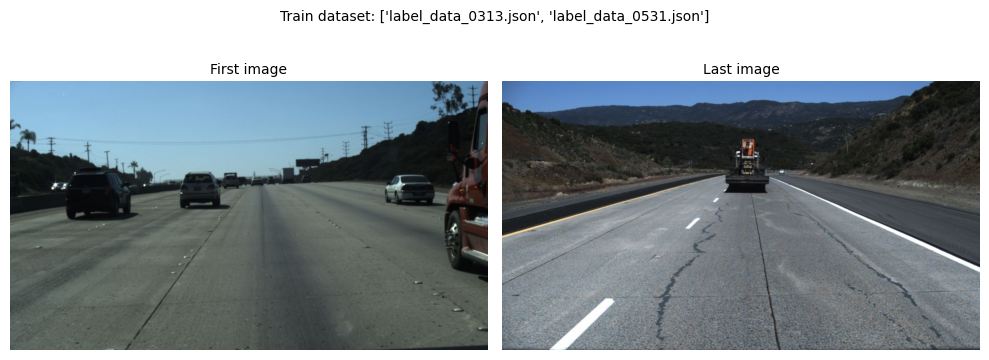

In [7]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(plt.imread(f"{train_dataset_path}/{train_data[0]['raw_file']}"))
plt.title('First image', size=10)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(plt.imread(f"{train_dataset_path}/{train_data[-1]['raw_file']}"))
plt.title('Last image', size=10)
plt.axis('off')
plt.suptitle(f'Train dataset: {train_json}', size=10)
plt.tight_layout();

In [8]:
DEFAULT_SIZE = (256, 512)
#import torch

In [9]:
class LaneDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path=dataset_path, mode='train', size=DEFAULT_SIZE):
        self.dataset_path = dataset_path
        self.image_size = size # w, h

        assert mode in ('train', 'val', 'test'), "mode should one of 'train', 'val', or 'test'"
        if mode == 'train':
            label_files = [self.dataset_path / 'train_set' / _ for _ in train_json]
            self.clips_path = 'train_set'
        elif mode == 'val':
            label_files = [self.dataset_path / 'train_set' / _ for _ in val_json]
            self.clips_path = 'train_set'
        else: # mode == 'test'
            label_files = [self.dataset_path / _ for _ in test_json]
            self.clips_path = 'test_set'

        self.data = []

        for label_file in label_files:
            self._process_label_file(label_file)

    def __getitem__(self, idx):
        # TODO
        image_path = self.dataset_path / self.clips_path / self.data[idx][0]
        #print(image_path)
        image = cv2.imread(image_path.__str__())
        h, w, c = image.shape
        image = cv2.resize(image, self.image_size, interpolation=cv2.INTER_LINEAR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image[..., None]
        lanes = self.data[idx][1]

        segmentation_image = self._draw(h, w, lanes, 'segmentation')
        instance_image = self._draw(h, w, lanes, 'instance')

        instance_image = instance_image[..., None]

        image = torch.from_numpy(image).float().permute((2, 0, 1))
        segmentation_image = torch.from_numpy(segmentation_image.copy())
        instance_image =  torch.from_numpy(instance_image.copy()).permute((2, 0, 1))
        segmentation_image = segmentation_image.to(torch.int64)

        return image, segmentation_image, instance_image # 1 x H x W [[0, 1], [2, 0]]

    def __len__(self):
        # TODO
        return len(self.data)
    
    def _draw(self, h, w, lanes, image_type):
        image = np.zeros((h, w), dtype=np.uint8)
        for i, lane in enumerate(lanes):
            color = 1 if image_type == 'segmentation' else i + 1
            cv2.polylines(image, [lane], False, color, 10)
        image = cv2.resize(image, self.image_size, interpolation=cv2.INTER_NEAREST)
        return image
    
    def _process_label_file(self, file_path):
        with open(file_path) as f:
            for line in f:
                info = json.loads(line)
                image = info['raw_file']
                lanes = info['lanes']
                h_samples = info['h_samples']
                lanes_coords = []
                for lane in lanes:
                    x = np.array([lane]).T
                    y = np.array([h_samples]).T
                    xy = np.hstack((x, y))
                    idx = np.where(xy[:, 0] > 0)
                    lane_coords = xy[idx]
                    lanes_coords.append(lane_coords)
                self.data.append((image, lanes_coords))

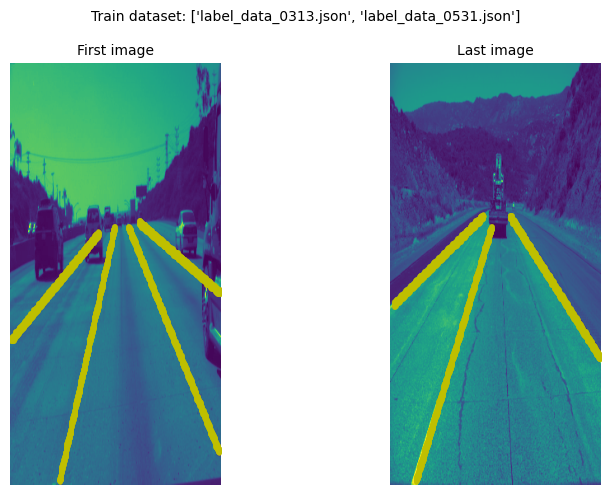

In [10]:
# Check
lanes_dataset = LaneDataset()
plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
im, seg, ins = lanes_dataset[0]
plt.scatter(x=ins.nonzero(as_tuple=True)[2], y=ins.nonzero(as_tuple=True)[1], s=5, c='y')
plt.imshow(im.squeeze())
plt.title('First image', size=10)
plt.axis('off')
plt.subplot(1, 2, 2)
im, seg, ins = lanes_dataset[-1]
plt.scatter(x=ins.nonzero(as_tuple=True)[2], y=ins.nonzero(as_tuple=True)[1], s=5, c='y')
plt.imshow(im.squeeze())
plt.title('Last image', size=10)
plt.axis('off')
plt.suptitle(f'Train dataset: {train_json}', size=10)
plt.tight_layout();

For this task we are going to use ENet architecture. You can read the description in the [original paper](https://arxiv.org/pdf/1606.02147.pdf).

To generate two different outputs we need to have two different branches. In the LaneNet paper authers proposed to share only two first sections of the encoder between to tasks. Third section and decoder should be separate for the instance segmentation and binary segmentation problem.

The output dimension of the instance segmentation embedding should be equal to 5.

In [11]:
class InitialBlock(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 bias=False,
                 relu=True):
        super().__init__()

        if relu:
            activation = nn.ReLU
        else:
            # Parametric ReLU
            activation = nn.PReLU

        # Main branch - As stated above the number of output channels for this
        # branch is the total minus 3, since the remaining channels come from
        # the extension branch
        self.main_branch = nn.Conv2d(
            in_channels,
            out_channels - 1,
            kernel_size=3,
            stride=2,
            padding=1,
            bias=bias)

        # Extension branch
        self.ext_branch = nn.MaxPool2d(3, stride=2, padding=1)

        # Initialize batch normalization to be used after concatenation
        self.batch_norm = nn.BatchNorm2d(out_channels)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        main = self.main_branch(x)
        ext = self.ext_branch(x)

        # Concatenate branches
        out = torch.cat((main, ext), 1)

        # Apply batch normalization
        out = self.batch_norm(out)

        return self.out_activation(out)

In [12]:
class RegularBottleneck(nn.Module):
    def __init__(self,
                 channels,
                 internal_ratio=4,
                 kernel_size=3,
                 padding=0,
                 dilation=1,
                 asymmetric=False,
                 dropout_prob=0.0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > channels:
            raise RuntimeError(f'Value out of range. Expected value in the interval [1, {channels}], got internal_scale={internal_ratio}.')

        internal_channels = channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            # Parametric ReLU
            activation = nn.PReLU

        # Main branch - shortcut connection

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution, and,
        # finally, a regularizer (spatial dropout). Number of channels is constant.

        # 1x1 projection convolution
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                channels,
                internal_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # If the convolution is asymmetric we split the main convolution in
        # two. Eg. for a 5x5 asymmetric convolution we have two convolution:
        # the first is 5x1 and the second is 1x5.
        if asymmetric:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(kernel_size, 1),
                    stride=1,
                    padding=(padding, 0),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation(),
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=(1, kernel_size),
                    stride=1,
                    padding=(0, padding),
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())
        else:
            self.ext_conv2 = nn.Sequential(
                nn.Conv2d(
                    internal_channels,
                    internal_channels,
                    kernel_size=kernel_size,
                    stride=1,
                    padding=padding,
                    dilation=dilation,
                    bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after adding the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        main = x

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)

In [13]:
class DownsamplingBottleneck(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 return_indices=False,
                 dropout_prob=0.0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Store parameters that are needed later
        self.return_indices = return_indices

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError(f'Value out of range. Expected value in the interval [1, {in_channels}], got internal_scale={internal_ratio}.')

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            # Parametric ReLU
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_max1 = nn.MaxPool2d(
            2,
            stride=2,
            return_indices=return_indices)

        # Extension branch - 2x2 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 2x2 projection convolution with stride 2
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels,
                internal_channels,
                kernel_size=2,
                stride=2,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # Convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                internal_channels,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=bias), nn.BatchNorm2d(internal_channels), activation())

        # 1x1 expansion convolution
        self.ext_conv3 = nn.Sequential(
            nn.Conv2d(
                internal_channels,
                out_channels,
                kernel_size=1,
                stride=1,
                bias=bias), nn.BatchNorm2d(out_channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x):
        # Main branch shortcut
        if self.return_indices:
            main, max_indices = self.main_max1(x)
        else:
            main = self.main_max1(x)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_conv2(ext)
        ext = self.ext_conv3(ext)
        ext = self.ext_regul(ext)

        # Main branch channel padding
        n, ch_ext, h, w = ext.size()
        ch_main = main.size()[1]
        padding = torch.zeros(n, ch_ext - ch_main, h, w)

        # Before concatenating, check if main is on the CPU or GPU and
        # convert padding accordingly
        if main.is_cuda:
            padding = padding.cuda()

        # Concatenate
        main = torch.cat((main, padding), 1)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out), max_indices

In [14]:
class UpsamplingBottleneck(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 internal_ratio=4,
                 dropout_prob=0.0,
                 bias=False,
                 relu=True):
        super().__init__()

        # Check in the internal_scale parameter is within the expected range
        # [1, channels]
        if internal_ratio <= 1 or internal_ratio > in_channels:
            raise RuntimeError(f'Value out of range. Expected value in the interval [1, {in_channels}], got internal_scale={internal_ratio}.')

        internal_channels = in_channels // internal_ratio

        if relu:
            activation = nn.ReLU
        else:
            # Parametric ReLU
            activation = nn.PReLU

        # Main branch - max pooling followed by feature map (channels) padding
        self.main_conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels))

        # Remember that the stride is the same as the kernel_size, just like
        # the max pooling layers
        self.main_unpool1 = nn.MaxUnpool2d(kernel_size=2)

        # Extension branch - 1x1 convolution, followed by a regular, dilated or
        # asymmetric convolution, followed by another 1x1 convolution. Number
        # of channels is doubled.

        # 1x1 projection convolution with stride 1
        self.ext_conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels, internal_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(internal_channels), activation())

        # Transposed convolution
        self.ext_tconv1 = nn.ConvTranspose2d(
            internal_channels,
            internal_channels,
            kernel_size=2,
            stride=2,
            bias=bias)
        self.ext_tconv1_bnorm = nn.BatchNorm2d(internal_channels)
        self.ext_tconv1_activation = activation()

        # 1x1 expansion convolution
        self.ext_conv2 = nn.Sequential(
            nn.Conv2d(
                internal_channels, out_channels, kernel_size=1, bias=bias),
            nn.BatchNorm2d(out_channels), activation())

        self.ext_regul = nn.Dropout2d(p=dropout_prob)

        # PReLU layer to apply after concatenating the branches
        self.out_activation = activation()

    def forward(self, x, max_indices, output_size):
        # Main branch shortcut
        main = self.main_conv1(x)
        main = self.main_unpool1(
            main, max_indices, output_size=output_size)

        # Extension branch
        ext = self.ext_conv1(x)
        ext = self.ext_tconv1(ext, output_size=output_size)
        ext = self.ext_tconv1_bnorm(ext)
        ext = self.ext_tconv1_activation(ext)
        ext = self.ext_conv2(ext)
        ext = self.ext_regul(ext)

        # Add main and extension branches
        out = main + ext

        return self.out_activation(out)

In [15]:
class ENet(nn.Module):
    def __init__(self, binary_seg, embedding_dim, encoder_relu=False, decoder_relu=True):
        super(ENet, self).__init__()

        # As per the ENet paper (Table 1: ENet architecture)

        # Initial block common
        self.initial_block = InitialBlock(1, 16, relu=encoder_relu)

        # Encoder stage
        # Block 1 common
        self.downsample1_0 = DownsamplingBottleneck(16, 64, return_indices=True, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_1 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_2 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_3 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)
        self.regular1_4 = RegularBottleneck(64, padding=1, dropout_prob=0.01, relu=encoder_relu)

        # Block 2 common
        self.downsample2_0 = DownsamplingBottleneck(64, 128, return_indices=True, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_1 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_2 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_3 = RegularBottleneck(128, asymmetric=True, kernel_size=5, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_4 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular2_5 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_6 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric2_7 = RegularBottleneck(128, asymmetric=True, kernel_size=5, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated2_8 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # Block 3 binary (repeat section 2, without bottleneck2.0)
        self.regular_binary_3_1 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_2 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_binary_3_3 = RegularBottleneck(128, asymmetric=True, kernel_size=5, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_4 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular_binary_3_5 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_6 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_binary_3_7 = RegularBottleneck(128, asymmetric=True, kernel_size=5, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_binary_3_8 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # Block 3 embedding (repeat section 2, without bottleneck2.0)
        self.regular_embedding_3_1 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_2 = RegularBottleneck(128, dilation=2, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_embedding_3_3 = RegularBottleneck(128, asymmetric=True, kernel_size=5, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_4 = RegularBottleneck(128, dilation=4, padding=4, dropout_prob=0.1, relu=encoder_relu)
        self.regular_embedding_3_5 = RegularBottleneck(128, padding=1, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_6 = RegularBottleneck(128, dilation=8, padding=8, dropout_prob=0.1, relu=encoder_relu)
        self.asymmetric_embedding_3_7 = RegularBottleneck(128, asymmetric=True, kernel_size=5, padding=2, dropout_prob=0.1, relu=encoder_relu)
        self.dilated_embedding_3_8 = RegularBottleneck(128, dilation=16, padding=16, dropout_prob=0.1, relu=encoder_relu)

        # Decoder stage
        # Block 4 binary
        self.upsample_binary_4_0 = UpsamplingBottleneck(128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_4_1 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_4_2 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        
        # Block 4 embedding
        self.upsample_embedding_4_0 = UpsamplingBottleneck(128, 64, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_4_1 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_4_2 = RegularBottleneck(64, padding=1, dropout_prob=0.1, relu=decoder_relu)
        
        # Block 5 binary
        self.upsample_binary_5_0 = UpsamplingBottleneck(64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular_binary_5_1 = RegularBottleneck(16, padding=1, dropout_prob=0.1, relu=decoder_relu)
        
        # Block 5 embedding
        self.upsample_embedding_5_0 = UpsamplingBottleneck(64, 16, dropout_prob=0.1, relu=decoder_relu)
        self.regular_embedding_5_1 = RegularBottleneck(16, padding=1, dropout_prob=0.1, relu=decoder_relu)

        # Final output
        # Fullconv block binary
        self.binary_transposed_conv = nn.ConvTranspose2d(16, binary_seg, kernel_size=3, stride=2, padding=1, bias=False)
        
        # Fullconv block embedding
        self.embedding_transposed_conv = nn.ConvTranspose2d(16, embedding_dim, kernel_size=3, stride=2, padding=1, bias=False)

    def forward(self, x):
        # TODO
        # As per the ENet paper (Table 1: ENet architecture)

        # Initial block common
        input_size = x.size()
        x = self.initial_block(x)

        # Encoder stage
        # Block 1 common
        stage1_input_size = x.size()
        x, max_indices1_0 = self.downsample1_0(x)
        x = self.regular1_1(x)
        x = self.regular1_2(x)
        x = self.regular1_3(x)
        x = self.regular1_4(x)

        # Block 2 common
        stage2_input_size = x.size()
        x, max_indices2_0 = self.downsample2_0(x)
        x = self.regular2_1(x)
        x = self.dilated2_2(x)
        x = self.asymmetric2_3(x)
        x = self.dilated2_4(x)
        x = self.regular2_5(x)
        x = self.dilated2_6(x)
        x = self.asymmetric2_7(x)
        x = self.dilated2_8(x)

        # Block 3 binary
        x_binary = self.regular_binary_3_1(x)
        x_binary = self.dilated_binary_3_2(x_binary)
        x_binary = self.asymmetric_binary_3_3(x_binary)
        x_binary = self.dilated_binary_3_4(x_binary)
        x_binary = self.regular_binary_3_5(x_binary)
        x_binary = self.dilated_binary_3_6(x_binary)
        x_binary = self.asymmetric_binary_3_7(x_binary)
        x_binary = self.dilated_binary_3_8(x_binary)

        # Block 3 embedding
        x_embedding = self.regular_embedding_3_1(x)
        x_embedding = self.dilated_embedding_3_2(x_embedding)
        x_embedding = self.asymmetric_embedding_3_3(x_embedding)
        x_embedding = self.dilated_embedding_3_4(x_embedding)
        x_embedding = self.regular_embedding_3_5(x_embedding)
        x_embedding = self.dilated_embedding_3_6(x_embedding)
        x_embedding = self.asymmetric_embedding_3_7(x_embedding)
        x_embedding = self.dilated_embedding_3_8(x_embedding)

        # Decoder stage
        # Block 4 binary
        x_binary = self.upsample_binary_4_0(x_binary, max_indices2_0, output_size=stage2_input_size)
        x_binary = self.regular_binary_4_1(x_binary)
        x_binary = self.regular_binary_4_2(x_binary)
        
        # Block 4 embedding
        x_embedding = self.upsample_embedding_4_0(x_embedding, max_indices2_0, output_size=stage2_input_size)
        x_embedding = self.regular_embedding_4_1(x_embedding)
        x_embedding = self.regular_embedding_4_2(x_embedding)
        
        # Block 5 binary
        x_binary = self.upsample_binary_5_0(x_binary, max_indices1_0, output_size=stage1_input_size)
        x_binary = self.regular_binary_5_1(x_binary)
        
        # Block 5 embedding
        x_embedding = self.upsample_embedding_5_0(x_embedding, max_indices1_0, output_size=stage1_input_size)
        x_embedding = self.regular_embedding_5_1(x_embedding)

        # Final output
        # Fullconv block binary
        binary_final_logits = self.binary_transposed_conv(x_binary, output_size=input_size)

        # Fullconv block embedding
        instance_final_logits = self.embedding_transposed_conv(x_embedding, output_size=input_size)

        return binary_final_logits, instance_final_logits

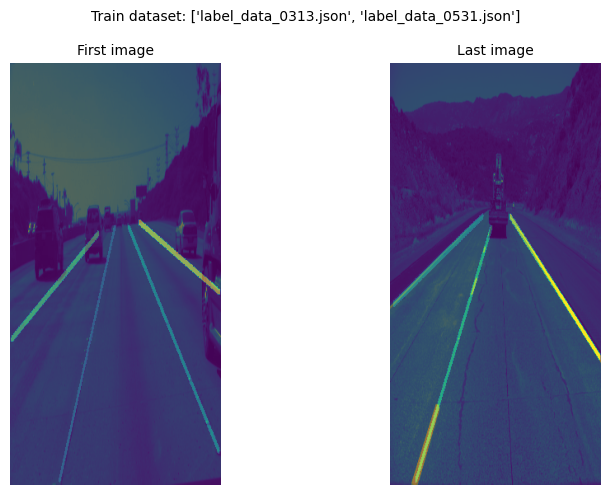

In [16]:
# Check (untrained)
enet = ENet(2, 4)
plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
im, seg, ins = lanes_dataset[0]
seg_pred, ins_pred = enet(im[None, ...])
plt.imshow(im.squeeze())
plt.imshow(ins.squeeze(), alpha=0.5)
plt.title('First image', size=10)
plt.axis('off')
plt.subplot(1, 2, 2)
im, seg, ins = lanes_dataset[len(train_data) - 1]
seg_pred, ins_pred = enet(im[None, ...])
plt.imshow(im.squeeze())
plt.imshow(ins.squeeze(), alpha=0.5)
plt.title('Last image', size=10)
plt.axis('off')
plt.suptitle(f'Train dataset: {train_json}', size=10)
plt.tight_layout();

To obtain the instance segmentation we should train the embeddings as we described in the project description. In order to do that we need to implement [Discriminative Loss](https://arxiv.org/pdf/1708.02551.pdf). Discriminative loss consists of three parts:

1. Inter-cluster push-force: cluster means should be far away from each other
2. Intra-cluster pull-force: embeddings should be close to the center of the corresponding cluster.
3. Regularization: cluster centers should be close to zero.

Corresponding weights for the losses and other hyper-parameters could be found in the paper.

In [17]:
class DiscriminativeLoss(torch.nn.modules.loss._Loss):
    #def __init__(self, size_average=True):
     #   super(DiscriminativeLoss, self).__init__(size_average=size_average)
    
    def __init__(self, 
                 delta_var=0.5, 
                 delta_dist=3,
                 norm=2, 
                 alpha=1.0, 
                 beta=1.0, 
                 gamma=1e-3,
                 device=device, 
                 reduction='mean', 
                 n_clusters=4):
        super(DiscriminativeLoss, self).__init__(reduction=reduction)
        # TODO

        self.delta_var = delta_var
        self.delta_dist = delta_dist
        self.norm = norm
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.device = device
        self.n_clusters = n_clusters
        assert self.norm in [1, 2]

    def forward(self, input, target):
        # TODO
        assert not target.requires_grad
        return self._discriminative_loss(input, target)
    
    def _discriminative_loss(self, input, target):
        num_samples=target.size(0)

        dis_loss = torch.tensor(0.0).to(self.device)
        var_loss = torch.tensor(0.0).to(self.device)
        reg_loss = torch.tensor(0.0).to(self.device)
        for i in range(num_samples):
            clusters = []
            sample_embedding = input[i, :, :, :]
            sample_label = target[i, :, :].squeeze()
            num_clusters = len(sample_label.unique()) - 1
            vals = sample_label.unique()[1:]
            sample_label = sample_label.view(sample_label.size(0) * sample_label.size(1))
            sample_embedding = sample_embedding.view(-1, sample_embedding.size(1) * sample_embedding.size(2))
            v_loss = torch.tensor(0.).to(self.device)
            d_loss = torch.tensor(0.).to(self.device)
            r_loss = torch.tensor(0.).to(self.device)
            for j in range(num_clusters):
                indices = (sample_label == vals[j]).nonzero()
                indices = indices.squeeze()
                cluster_elements = torch.index_select(sample_embedding, 1, indices)
                Nc = cluster_elements.size(1)
                mean_cluster = cluster_elements.mean(dim=1, keepdim=True)
                clusters.append(mean_cluster)
                v_loss += torch.pow((torch.clamp(torch.norm(cluster_elements - mean_cluster) - self.delta_var, min=0.0)), 2).sum() / Nc
                r_loss += torch.sum(torch.abs(mean_cluster))
            for index in range(num_clusters):
                for idx, cluster in enumerate(clusters):
                    if index == idx:
                        continue 
                    else:
                        distance = torch.norm(clusters[index] - cluster)#torch.sqrt(torch.sum(torch.pow(clusters[index]-cluster,2)))
                        d_loss += torch.pow(torch.clamp(self.delta_dist - distance, min=0.0), 2)
            var_loss += v_loss / num_clusters
            dis_loss += d_loss / (num_clusters * (num_clusters - 1))
            reg_loss += r_loss / num_clusters
        return self.alpha * (var_loss/num_samples) + self.beta * (dis_loss / num_samples) + self.gamma * (reg_loss / num_samples)

In [18]:
# Check
DiscriminativeLoss(delta_var=0.5, delta_dist=3, alpha=1.0, beta=1.0, gamma=1e-3)(ins_pred, ins)

tensor(13.3878, device='cuda:0', grad_fn=<AddBackward0>)

In [19]:
def compute_loss(binary_output, instance_output, binary_label, instance_label):
    ce_loss = nn.CrossEntropyLoss()
    binary_loss = ce_loss(binary_output, binary_label)

    ds_loss = DiscriminativeLoss(delta_var=0.5, delta_dist=3, alpha=1.0, beta=1.0, gamma=0.001, device=device)
    instance_loss = ds_loss(instance_output, instance_label)
    
    return binary_loss, instance_loss

In [20]:
def plot_metrics(model_name: str, metrics: dict, epochs: int):
    '''
    Plot model's loss and accuracy metrics obtained during train/val over the number of epochs.
    '''
    n_metrics = len(metrics)
    n_cols = 2
    n_rows = n_metrics // n_cols
    plt.figure(figsize=(n_cols * 5, n_rows * 3.5))
    for i, metric in enumerate(metrics, start=1):
        #print(i)
        #print(metric)
        plt.subplot(n_rows, n_cols, i)
        if isinstance(metrics[metric], dict): # sub-metrics
            for item in metrics[metric]:
                #print(item)
                plt.plot(range(1, epochs+1), metrics[metric][item], label=f'{item}')
        else: # plain list
            plt.plot(range(1, epochs+1), metrics[metric], label=f'{metric}')
        plt.xticks(range(1, epochs + 1))
        plt.xlabel('Epoch')
        plt.ylabel(f'{metric}')
        plt.legend()
        plt.grid(lw=0.5)
    plt.suptitle(f'Train and validation datasets metrics for: {model_name}', fontsize=11)
    plt.tight_layout();

Now we are ready to train the network. You may want to create validation subset to track metrics.

In [21]:
# TODO: Train segmentation and instance segmentation
enet_epochs = 10
batch_size = 8
enet_model = ENet(2, 4)
enet_model.to(device)
params = [p for p in enet_model.parameters() if p.requires_grad]
# Best hyperparams, as per the ENet paper (5.2 Benchmarks)
lr = 5e-4
weight_decay = 2e-4
optimizer = torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)

train_dataset = LaneDataset(mode='train')
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataset = LaneDataset(mode='val')
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

enet_metrics = {'train_losses': {'binary': [], 'instance': []}, 
                'train_accs': [], 
                'val_losses': {'binary': [], 'instance': []}, 
                'val_accs': []}

for epoch in range(1, enet_epochs + 1):
    print(f'-------------\nEpoch: {epoch:>2}/{enet_epochs}')

    # Train
    enet_model.train()
    losses, accs = [], []
    for batch in tqdm(train_dataloader):
        img, binary_target, instance_target = batch
        img = img.to(device)
        binary_target = binary_target.to(device)
        instance_target = instance_target.to(device)
        optimizer.zero_grad()
        binary_logits, instance_emb = enet_model(img)
        binary_loss, instance_loss = compute_loss(binary_logits, instance_emb, binary_target, instance_target)
        loss = binary_loss + instance_loss
        loss.backward()
        optimizer.step()
        losses.append((binary_loss.detach().cpu(), instance_loss.detach().cpu()))
        acc = torch.mean(binary_logits.argmax(axis=1) == binary_target, dtype=torch.float32) # normalized accuracy_score (sklearn)
        accs.append(acc.item())
    
    # Train metrics
    mean_losses = np.array(losses).mean(axis=0)
    enet_metrics['train_losses']['binary'].append(mean_losses[0])
    enet_metrics['train_losses']['instance'].append(mean_losses[1])
    mean_acc = np.mean(accs)
    enet_metrics['train_accs'].append(mean_acc)

    # Eval
    enet_model.eval()
    losses, accs = [], []
    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            img, binary_target, instance_target = batch
            img = img.to(device)
            binary_target = binary_target.to(device)
            instance_target = instance_target.to(device)
            binary_logits, instance_emb = enet_model(img)
            binary_loss, instance_loss = compute_loss(binary_logits, instance_emb, binary_target, instance_target)
            loss = binary_loss + instance_loss
            losses.append((binary_loss.detach().cpu(), instance_loss.detach().cpu()))
            acc = torch.mean(binary_logits.argmax(axis=1) == binary_target, dtype=torch.float32) # normalized accuracy_score (sklearn)
            accs.append(acc.item())
    
    # Val metrics
    mean_losses = np.array(losses).mean(axis=0)
    enet_metrics['val_losses']['binary'].append(mean_losses[0])
    enet_metrics['val_losses']['instance'].append(mean_losses[1])
    mean_acc = np.mean(accs)
    enet_metrics['val_accs'].append(mean_acc)

    print(f"Epoch avg: Train losses: {enet_metrics['train_losses']['binary'][-1]:.2f} (binary), "
          f"{enet_metrics['train_losses']['instance'][-1]:.2f} (instance), "
          f"Train accuracy: {enet_metrics['train_accs'][-1]:.2f}, "
          f"Val losses: {enet_metrics['val_losses']['binary'][-1]:.2f} (binary), "
          f"{enet_metrics['val_losses']['instance'][-1]:.2f} (instance), "
          f"Val accuracy: {enet_metrics['val_accs'][-1]:.2f}")

-------------
Epoch:  1/10


100%|██████████| 52/52 [00:16<00:00,  3.09it/s]


Epoch avg: Train losses: 0.15 (binary), 1.90 (instance), Train accuracy: 0.95, Val losses: 0.09 (binary), 1.37 (instance), Val accuracy: 0.97
-------------
Epoch:  2/10


100%|██████████| 52/52 [00:15<00:00,  3.41it/s]


Epoch avg: Train losses: 0.06 (binary), 0.33 (instance), Train accuracy: 0.98, Val losses: 0.08 (binary), 1.06 (instance), Val accuracy: 0.97
-------------
Epoch:  3/10


100%|██████████| 52/52 [00:15<00:00,  3.27it/s]


Epoch avg: Train losses: 0.05 (binary), 0.21 (instance), Train accuracy: 0.98, Val losses: 0.07 (binary), 1.00 (instance), Val accuracy: 0.97
-------------
Epoch:  4/10


100%|██████████| 52/52 [00:14<00:00,  3.71it/s]


Epoch avg: Train losses: 0.05 (binary), 0.15 (instance), Train accuracy: 0.98, Val losses: 0.07 (binary), 0.89 (instance), Val accuracy: 0.97
-------------
Epoch:  5/10


100%|██████████| 52/52 [00:14<00:00,  3.61it/s]


Epoch avg: Train losses: 0.05 (binary), 0.13 (instance), Train accuracy: 0.98, Val losses: 0.07 (binary), 0.96 (instance), Val accuracy: 0.97
-------------
Epoch:  6/10


100%|██████████| 52/52 [00:14<00:00,  3.59it/s]


Epoch avg: Train losses: 0.05 (binary), 0.12 (instance), Train accuracy: 0.98, Val losses: 0.07 (binary), 0.86 (instance), Val accuracy: 0.98
-------------
Epoch:  7/10


100%|██████████| 52/52 [00:15<00:00,  3.46it/s]


Epoch avg: Train losses: 0.05 (binary), 0.10 (instance), Train accuracy: 0.98, Val losses: 0.07 (binary), 0.99 (instance), Val accuracy: 0.97
-------------
Epoch:  8/10


100%|██████████| 52/52 [00:14<00:00,  3.67it/s]


Epoch avg: Train losses: 0.04 (binary), 0.09 (instance), Train accuracy: 0.98, Val losses: 0.07 (binary), 0.91 (instance), Val accuracy: 0.98
-------------
Epoch:  9/10


100%|██████████| 52/52 [00:23<00:00,  2.21it/s]


Epoch avg: Train losses: 0.04 (binary), 0.08 (instance), Train accuracy: 0.98, Val losses: 0.07 (binary), 0.89 (instance), Val accuracy: 0.98
-------------
Epoch: 10/10


100%|██████████| 52/52 [00:23<00:00,  2.23it/s]

Epoch avg: Train losses: 0.04 (binary), 0.07 (instance), Train accuracy: 0.98, Val losses: 0.07 (binary), 0.83 (instance), Val accuracy: 0.98


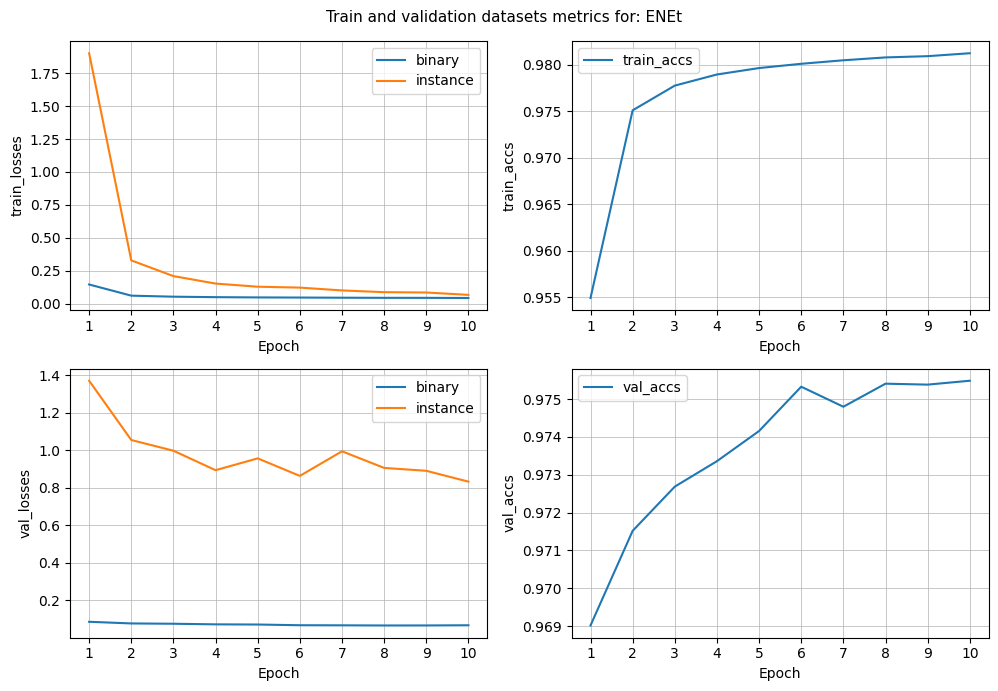

In [22]:
plot_metrics('ENEt', enet_metrics, epochs=enet_epochs)

Let's also compute the ENet accuracy on the test data.

In [ ]:
# Test ENet on test_dataset -- compute accuracy
batch_size = 8
test_dataset = LaneDataset(mode='test')
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Test
enet_model.eval()
accs = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        img, binary_target, instance_target = batch
        img = img.to(device)
        binary_target = binary_target.to(device)
        instance_target = instance_target.to(device)
        binary_logits, instance_emb = enet_model(img)
        acc = torch.mean(binary_logits.argmax(axis=1) == binary_target, dtype=torch.float32) # normalized accuracy_score (sklearn)
        accs.append(acc.item())

mean_acc = np.mean(accs)

print(f'Test accuracy: {mean_acc:.2f}')

In [ ]:
# Check (trained)
enet_val_dataset = LaneDataset(mode='val')
plt.figure(figsize=(12, 9))
enet_val_im, *_ = enet_val_dataset[0]
enet_val_im = enet_val_im.to(device)
binary_logits, instance_emb = enet_model(enet_val_im[None, ...])
plt.subplot(2, 3, 1)
plt.imshow(enet_val_im.squeeze().cpu())
plt.title('First image', size=10)
plt.axis('off')
plt.subplot(2, 3, 2)
plt.imshow(binary_logits.squeeze().argmax(axis=0).cpu())
plt.title('Binary', size=10)
plt.axis('off')
plt.subplot(2, 3, 3)
plt.imshow(instance_emb.squeeze()[:, :, :].argmax(axis=0).cpu())
plt.title('Instance', size=10)
plt.axis('off')
enet_val_im, *_ = enet_val_dataset[-1]
enet_val_im = enet_val_im.to(device)
binary_logits, instance_emb = enet_model(enet_val_im[None, ...])
plt.subplot(2, 3, 4)
plt.imshow(enet_val_im.squeeze().cpu())
plt.title('Last image', size=10)
plt.axis('off')
plt.subplot(2, 3, 5)
plt.imshow(binary_logits.squeeze().argmax(axis=0).cpu())
plt.title('Binary', size=10)
plt.axis('off')
plt.subplot(2, 3, 6)
plt.imshow(instance_emb.squeeze()[:, :, :].argmax(axis=0).cpu())
plt.title('Instance', size=10)
plt.axis('off')
plt.suptitle(f'Validation dataset: {val_json}', size=10)
plt.tight_layout();

## <a id="homography"></a> Homography Prediction Code

Here we again need to implement the Dataset class. Dataset class should return resized image and ground truth points for the lane trajectories.


In [24]:
HNET_DEFAULT_SIZE = (64, 128)
#import torch

In [25]:
class HomographyPredictionDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path=train_dataset_path, train=True, size=HNET_DEFAULT_SIZE):
        # TODO
        self.dataset_path = dataset_path
        self.size = size
        self.image_list = []
        self.lanes_list = []
        self.max_lanes = 0
        self.max_points = 0

        assert self.dataset_path.is_dir(), f'Directory {self.dataset_path} does not exist!'

        label_files = []
        if train:
            label_files = [self.dataset_path / _ for _ in train_json]
        else: # train == False
            label_files = [self.dataset_path / _ for _ in val_json]

        for file in label_files:
            try:
                for line in open(file).readlines():
                    info_dict = json.loads(line)
                    self.image_list.append(info_dict['raw_file'])
                    h_samples = info_dict['h_samples']
                    lanes = info_dict['lanes']
                    self.max_lanes = max(self.max_lanes, len(lanes))
                    xy_list = []

                    for lane in lanes:
                        y = np.array([h_samples], dtype=np.float64).T
                        x = np.array([lane], dtype=np.float64).T
                        xy = np.hstack((x, y))
                        index = np.where(xy[:, 0] > 2)
                        xy_list.append(xy[index])
                        self.max_points = max(self.max_points, len(xy[index]))
                    self.lanes_list.append(xy_list)
            except BaseException:
                raise Exception(f'Fail to load {file}')


    def __getitem__(self, idx):
        # TODO
        img_path = self.dataset_path / self.image_list[idx]

        image = cv2.imread(img_path.__str__(), cv2.IMREAD_COLOR)
        original_height, original_width, _ = image.shape
        image = cv2.resize(image, self.size, interpolation=cv2.INTER_LINEAR)

        image = np.transpose(image, (2, 0, 1))
        image = torch.from_numpy(image).float() / 255

        # creating output with shape [max_lanes, 2, max_points]
        buffer = None

        for lane in self.lanes_list[idx]:
            lane = np.expand_dims(np.pad(np.swapaxes(lane, 0, 1),
                                         pad_width=((0, 0), (0, self.max_points - lane.shape[0])),
                                         mode='constant',
                                         constant_values=0), 0)

            if buffer is not None:
                buffer = np.concatenate((buffer, lane), 0)
            else:
                buffer = lane
        
        # Scale lane coords
        buffer[:, 0, :] /= original_width
        buffer[:, 0, :] *= self.size[0]
        buffer[:, 1, :] /= original_height
        buffer[:, 1, :] *= self.size[1]
        
        ground_truth_trajectory = torch.from_numpy(np.pad(buffer,
                                                          pad_width=((0, self.max_lanes - buffer.shape[0]),
                                                                     (0, 0),
                                                                     (0, 0)),
                                                          mode='constant',
                                                          constant_values=0))
        
        return image, ground_truth_trajectory

    def __len__(self):
        # TODO
        return len(self.image_list)

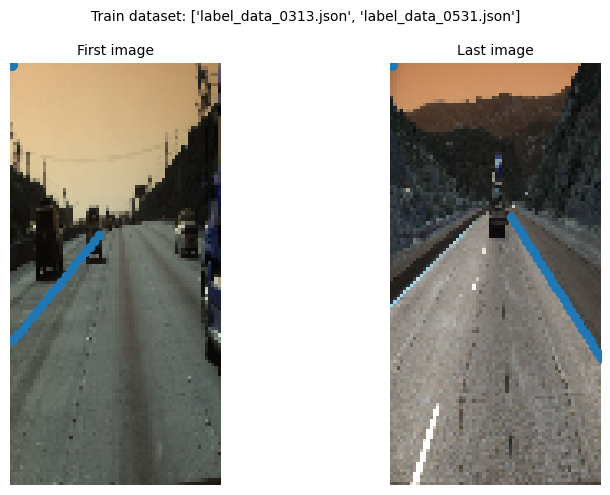

In [26]:
# Check
homography_dataset = HomographyPredictionDataset()
plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
plt.imshow(homography_dataset[0][0].permute(1, 2, 0))
plt.scatter(x=homography_dataset[0][1][2][0], y=homography_dataset[0][1][2][1])
plt.title('First image', size=10)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(homography_dataset[len(homography_dataset) - 1][0].permute(1, 2, 0))
plt.scatter(x=homography_dataset[len(homography_dataset) - 1][1][2][0], y=homography_dataset[len(homography_dataset) - 1][1][2][1])
plt.title('Last image', size=10)
plt.axis('off')
plt.suptitle(f'Train dataset: {train_json}', size=10)
plt.tight_layout();

Now we need to implement the H-Net. It should return homography matrix that is parametrized by 6 numbers.
Corresponding section is CURVE FITTING USING H-NET in the[ LaneNet paper](https://arxiv.org/pdf/1802.05591.pdf).

We suggest to follow the paper and take 64x128 image as in input.

Homography projection contains discontinuities, therefore it could be quite difficult to train the network. In order to simplify the problem we propose not to train the homography from scratch, but train some correction to a good starting point.

The following code block contains the initial homography that you can use.


In [27]:
#import torch

# important note: this homography matrix is suitable only for 64x128 resolution
R = torch.Tensor([[-2.0484e-01, -1.7122e+01,  3.7991e+02],
                  [ 0.0000e+00, -1.6969e+01,  3.7068e+02],
                  [ 0.0000e+00, -4.6739e-02,  1.0000e+00]])

Let's check the effect of this homography on the image.

In [28]:
# !wget https://miro.medium.com/max/2560/1*b3HiwPg69Rw0L5iIMQMXOw.jpeg

In [29]:
#from matplotlib import pyplot as plt
#import cv2

In [30]:
image = plt.imread('./1_b3HiwPg69Rw0L5iIMQMXOw.jpg')

In [31]:
image = cv2.resize(image, (128, 64))

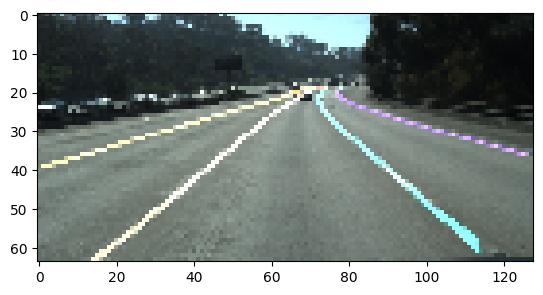

In [32]:
plt.imshow(image);

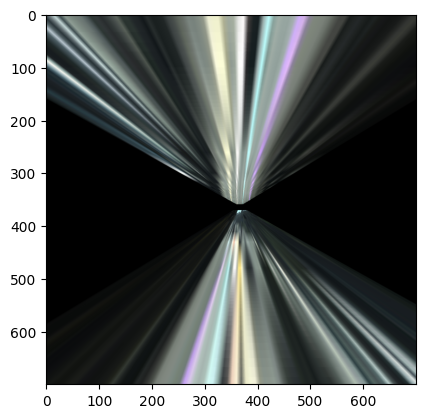

In [33]:
plt.imshow(cv2.warpPerspective(image, R.numpy(), dsize=(700, 700)));

As you can see it looks like a bird's eye view projection where lines are becoming parallel.

In [34]:
class HNet(nn.Module):
    def __init__(self):
        super(HNet, self).__init__()
        # TODO
        # As per the LaneNet paper (Table 1: H-NET network architecture)
        
        self.conv1 = nn.Conv2d(3, 16, 3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16, 16, 3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16, 32, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(32)

        self.conv4 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(32)

        self.conv5 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(64)

        self.conv6 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(64)

        self.ln1 = nn.Linear(8192, 1024)
        self.bn7 = nn.BatchNorm1d(1024)
        
        self.ln2 = nn.Linear(1024, 6)       
    
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(2, stride=2)

    def forward(self, x):
        # TODO
        # As per the LaneNet paper (Table 1: H-NET network architecture)
        # Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        # Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        # Block 3
        x = self.maxpool(x)

        # Block 4
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        # Block 5
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        
        # Block 6
        x = self.maxpool(x)

        # Block 7
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu(x)
        
        # Block 8
        x = self.conv6(x)
        x = self.bn6(x)
        x = self.relu(x)
        
        # Block 9
        x = self.maxpool(x)
        
        # Block 10
        x = x.view(x.size(0), -1)
        x = self.ln1(x)
        x = self.bn7(x)
        x = self.relu(x)

        # Final output: a, b, c, d, e, f (6) degrees of freedom
        x = self.ln2(x)        
        
        return x

Finally, we need to implement the loss to fit the network. This is the most difficult part of the project. Homography loss should do the following:

1. Project ground truth trajectory to the new plane according to the homography to obtain $(x', y')$.
2. Perform polynomial fitting $x' = f(y')$. Your code should work correctly with 2-nd and 3-rd order polynomials. Polynomial fitting should be done with the closed-form solution: $w = (Y^TY)^{-1}Y^Tx$ to be able to pass a gradient through.
3. Compute back projection with the inverse homography.
4. Compute loss between back projected $\hat{x}$ and ground truth $x$.

The full description can be found in the [LaneNet paper](https://arxiv.org/pdf/1802.05591.pdf).

**IMPORTANT NOTES**

* To fit the polynomial you need to compute the inverse matrix. Computation of the inverse is computation unstable operation. With the help of the SVD you can compute pseudo-inverse matrix: $(X^TX)^{-1}X^T$. In torch this function is called `torch.pinverse`.
* After projection use of the raw $y'$ can be impractical. The features for the polynomial fitting could have a high correlation and therefore solution can be unstable. At first, you need to map $y'$ to some fixed size segment and only then perform a fit.
* After projection some points can occur on the other side of image (bottom part of the projection in the example above). You may want to exclude them, because otherwise polynomial is not going to have much sense and gradients can have a dramatically large values. Positive $w$ in homogeneous coordinates indicates that point is on the wrong side.
* If use the homography provided above, your ground truth should have the same scale, as an image
* Every division in your network is a potential place to obtain `nan` in gradients. Use the following trick to obtain less divisions:
after computing the projection, remember the $w$. Then, before the back projection, multiply your vector by $w$. After back projection you will see that $w$ is equal to 1. So you don't need to devide your vector by $w$.
* You correction to the initial homography could be very big and can completely spoil the homography. So you may need to scale the output of the last layer in the HNet to obtain a smaller corrections.


In [35]:
class HomographyLoss(torch.nn.modules.loss._Loss):
    #def __init__(self, size_average=True):
     #   super(HomographyLoss, self).__init__(size_average=size_average)

    def __init__(self, reduction='mean', order=2, device=device):
        super(HomographyLoss, self).__init__(reduction=reduction)
        self.order = order
        self.fixed_homography = torch.tensor(
            [[-2.0484e-01, -1.7122e+01,  3.7991e+02],
             [ 0.0000e+00, -1.6969e+01,  3.7068e+02],
             [ 0.0000e+00, -4.6739e-02,  1.0000e+00]],
            dtype=torch.float32, device=device
        )

    def forward(self, input, target):
        # TODO
        assert input.shape[0] == target.shape[0], (
            'Number of items in batch for input and target must be the same, '
            f'got n_input={input.shape[0]}, n_target={target.shape[0]}'
            )
        losses = []
        # gt_lanes -- ground-truth lanes
        for correction, gt_lanes in zip(input, target):
            #print(correction, gt_lanes)
            for lane in gt_lanes:
                if lane.sum() == 0:
                    continue
                lane_loss = self.compute_loss_for_lane(correction, lane)
                if lane_loss is None:
                    continue
                losses.append(lane_loss)

        return torch.stack(losses).mean()
    
    def compute_loss_for_lane(self, correction, lane):
        '''
        As per the LaneNet paper (II. Method B. Curve fitting using H-Net)

            | a b c |
        H = | 0 d e |
            | 0 f 1 |
        '''
        H_correction_indices = [0, 1, 2, 4, 5, 7]
        H_correction = correction.flatten()
        H = self.fixed_homography.flatten().clone()
        H[H_correction_indices] = H_correction
        H = H.reshape((3, 3))
        
        points = lane.T
        #print(points)
        #print(points, points.nonzero())
        index = points.nonzero().flatten().max().item() + 1
        #print(index)
        points = points[:index, :]
        ones_col = torch.ones(points.shape[0], device=device)
        P = torch.column_stack((points, ones_col)).T.to(torch.float32)
        P_transformed = H @ P
        
        x_transformed = P_transformed[0, :].T # N×1
        y_transformed_squares = P_transformed[1, :] ** 2
        y_transformed = P_transformed[1, :]
        Y = torch.column_stack((y_transformed_squares, y_transformed, ones_col)) # N×3
        #print((Y.T @ Y).isnan().sum())
        w = torch.linalg.solve(Y.T @ Y, Y.T) @ x_transformed # 3×N @ N×3 @ 3×N @ N×1 = 3×1
        
        x_predicted = Y @ w # N×3 @ 3×1 = N×1
        P_predicted = torch.column_stack((x_predicted, y_transformed, ones_col)).T # 3×N
        P_reprojected = torch.linalg.inv(H.detach()) @ P_predicted # 3×3 @ 3×N = 3×N
        
        P_reprojected = torch.div(P_reprojected, P_reprojected[2, :])
        
        #print(points[:, 0].T.shape, P_reprojected[0, :].shape)
        #print(P_reprojected)
        
        loss = ((points[:, 0].T - P_reprojected[0, :]) ** 2).mean()
        
        return loss

In [53]:
# Check (untrained)
hnet = HNet()
# BatchNorm1d needs at least two objects to compute mean / std over, so stack the same image twice
batch = torch.stack((homography_dataset[0][0], homography_dataset[0][0]))
predicted_corrections = hnet(batch)[0]
predicted_corrections

tensor([ 0.0140,  0.0022,  0.0245,  0.0099, -0.0121, -0.0061],
       grad_fn=<SelectBackward0>)

In [54]:
R_corrected = torch.tensor(
    [
        [R[0, 0] + predicted_corrections[0], R[0, 1] + predicted_corrections[1], R[0, 2] + predicted_corrections[2]],
        [R[1, 0], R[1, 1] + predicted_corrections[3], R[1, 2] + predicted_corrections[4]],
        [R[2, 0], R[2, 1] + predicted_corrections[5], R[2, 2]]
    ]
)
R_corrected

tensor([[-1.9084e-01, -1.7120e+01,  3.7993e+02],
        [ 0.0000e+00, -1.6959e+01,  3.7067e+02],
        [ 0.0000e+00, -5.2815e-02,  1.0000e+00]])

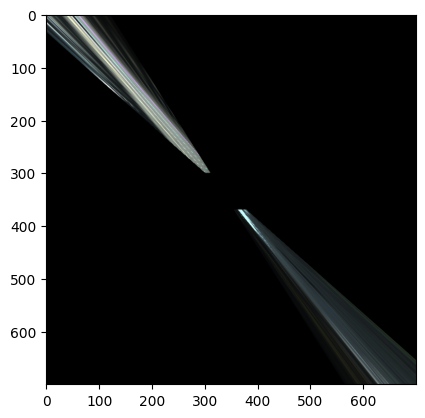

In [55]:
plt.imshow(cv2.warpPerspective(image, R_corrected.numpy(), dsize=(700, 700)));

Finally, train the homography net with the 2-nd order polynomial fitting (you can 3-rd order but we found out that it is much easier to train h-net with the 2-nd order polynomials).

We found out that SGD fits much better for this architectures. Adam (and momentums inside) can ruin the weights because of the discontinuities in the target function surface.

Demonstrate the difference in homography loss between h-net and provided fixed homography on the validation samples.

In [68]:
# Train the H-Net
hnet_epochs = 10
batch_size = 8
hnet_model = HNet()
hnet_model.to(device)
params = [p for p in hnet_model.parameters() if p.requires_grad]
# Used hyperparams, as per the LaneNet paper (III. Results B. Setup)
lr = 5e-5
# Though it was not used in the paper, apply some weight decay for convergence
weight_decay = 1e-1
optimizer = torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)
#optimizer = torch.optim.SGD(params, lr=lr)

train_dataset = HomographyPredictionDataset()
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataset = HomographyPredictionDataset(train=False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

criterion = HomographyLoss(device=device)

hnet_metrics = {'train_loss': [], 'val_loss': []}

for epoch in range(1, hnet_epochs + 1):
    print(f'-------------\nEpoch: {epoch:>2}/{hnet_epochs}')
    
    # Train
    hnet_model.train()
    losses = []
    for batch in tqdm(train_dataloader):
        inputs, points = batch
        inputs = inputs.to(device)
        points = points.to(device)
        optimizer.zero_grad()
        # Learn corrections for degrees of freedom
        dofs_corrections = hnet_model(inputs)
        loss = criterion(dofs_corrections, points)
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    
    # Train metrics
    mean_losses = np.array(losses).mean()
    hnet_metrics['train_loss'].append(mean_losses)

    # Eval
    hnet_model.eval()
    losses = []
    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            inputs, points = batch
            inputs = inputs.to(device)
            points = points.to(device)
            dofs_corrections = hnet_model(inputs)
            loss = criterion(dofs_corrections, points)        
            losses.append(loss.detach().cpu().numpy())
    
    # Val metrics
    mean_losses = np.array(losses).mean()
    hnet_metrics['val_loss'].append(mean_losses)

    print(f"Epoch avg: Train loss: {hnet_metrics['train_loss'][-1]:.2f}, "
          f"Val loss: {hnet_metrics['val_loss'][-1]:.2f}")    

-------------
Epoch:  1/10


100%|██████████| 52/52 [00:06<00:00,  7.85it/s]


Epoch avg: Train loss: 600627780.56, Val loss: 455442.28
-------------
Epoch:  2/10


100%|██████████| 52/52 [00:06<00:00,  8.02it/s]


Epoch avg: Train loss: 41364751.48, Val loss: 798936.01
-------------
Epoch:  3/10


100%|██████████| 52/52 [00:06<00:00,  8.06it/s]


Epoch avg: Train loss: 1084411.16, Val loss: 163.46
-------------
Epoch:  4/10


100%|██████████| 52/52 [00:06<00:00,  8.10it/s]


Epoch avg: Train loss: 302.65, Val loss: 4.65
-------------
Epoch:  5/10


100%|██████████| 52/52 [00:06<00:00,  7.82it/s]


Epoch avg: Train loss: 666.54, Val loss: 0.13
-------------
Epoch:  6/10


100%|██████████| 52/52 [00:06<00:00,  7.76it/s]


Epoch avg: Train loss: 0.09, Val loss: 0.12
-------------
Epoch:  7/10


100%|██████████| 52/52 [00:06<00:00,  7.63it/s]


Epoch avg: Train loss: 0.09, Val loss: 0.12
-------------
Epoch:  8/10


100%|██████████| 52/52 [00:06<00:00,  8.13it/s]


Epoch avg: Train loss: 0.09, Val loss: 0.12
-------------
Epoch:  9/10


100%|██████████| 52/52 [00:07<00:00,  6.62it/s]


Epoch avg: Train loss: 0.09, Val loss: 0.12
-------------
Epoch: 10/10


100%|██████████| 52/52 [00:06<00:00,  7.93it/s]

Epoch avg: Train loss: 0.09, Val loss: 0.12


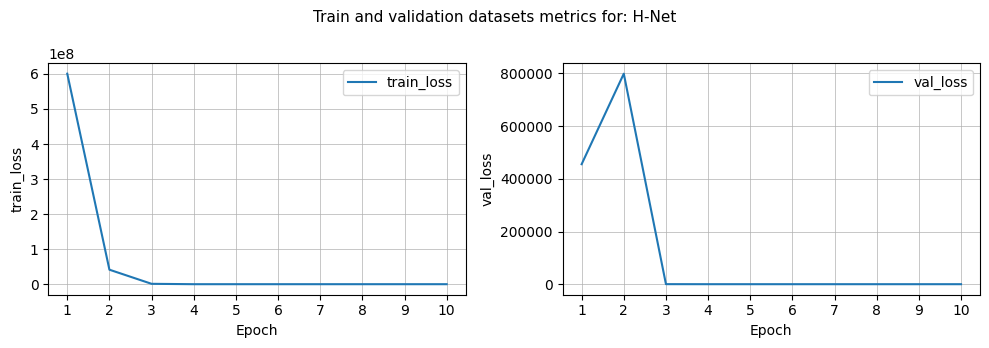

In [69]:
plot_metrics('H-Net', hnet_metrics, epochs=hnet_epochs)

# <a id="pipeline"></a> Complete Pipeline

Now you need to implement a class that takes image and a set of $y$ coordinates as an input and returns the $x$ coordinate for each lane in this image.

It should contain the following steps:

1. Apply segmentation network to the image
2. Run DBSCAN over the embeddings for those pixels that are lanes.
3. Apply h-net to the image
4. Project pixel coordinates with the predicted homograpgy
5. Fit the 3-rd order polynomial
6. Predict the lane position for each provided $y$ (you should project this first).
7. Compute back projection and return the positions of $x$ for each lane.

Note: if you weren't able to train the H-Net, you can use the fixed homography here.

In [70]:
class LaneDetector:    
    def __init__(self, hnet, lanenet, with_projection=False):
        self.enet = lanenet
        self.hnet = hnet
        self.fixed_homography = torch.tensor(
            [[-2.0484e-01, -1.7122e+01,  3.7991e+02],
             [ 0.0000e+00, -1.6969e+01,  3.7068e+02],
             [ 0.0000e+00, -4.6739e-02,  1.0000e+00]],
            dtype=torch.float32, device=device
        )
        self.eps = 1.0
        self.with_projection = with_projection
  
    def __call__(self, image, y_positions=None):
        if self.hnet:
            # Correct homography from the pretrained H-Net model
            # Resize for H-Net
            im_hnet = cv2.resize(image, HNET_DEFAULT_SIZE, interpolation=cv2.INTER_LINEAR)
            im_hnet = torch.tensor(im_hnet, dtype=torch.float32).permute((2, 0, 1)).to(device)
            # BatchNorm1d needs at least two objects to compute mean / std over, so stack the same image twice
            batch = torch.stack((im_hnet, im_hnet))
            dofs_corrections = self.hnet(batch)[0]
            self.homography = torch.tensor(
                [[self.fixed_homography[0, 0] + dofs_corrections[0], self.fixed_homography[0, 1] + dofs_corrections[1], self.fixed_homography[0, 2] + dofs_corrections[2]],
                [self.fixed_homography[1, 0], self.fixed_homography[1, 1] + dofs_corrections[3], self.fixed_homography[1, 2] + dofs_corrections[4]],
                [self.fixed_homography[2, 0], self.fixed_homography[2, 1] + dofs_corrections[5], self.fixed_homography[2, 2]]])
        else: # self.hnet == None => Use fixed homography
            self.homography = self.fixed_homography
        # Resize for ENet
        image = self._preprocess_image(image, DEFAULT_SIZE)
        if y_positions is None:
            y_positions = np.linspace(50, image.shape[2], 30)
        #print(image.shape)
        binary_logits, instance_embeddings = self.enet(image)
        segmentation_map = binary_logits.squeeze().argmax(dim=0)
        instances_map = self._cluster(segmentation_map, instance_embeddings)
        lanes = self._extract_lanes(instances_map)
        #print(f'Detected {len(lanes)} lanes')
        #print(lanes)
        if self.with_projection:
            projected_lanes = self._project_lanes(lanes)
            #print(projected_lanes)
            coefs = self._fit(projected_lanes)
            #print(lanes[0])
            #print(projected_lanes[0])
            print(coefs)
            y_positions_projected = self._project_y(y_positions)
            #print(y_positions_projected)
            fitted_lanes = self._predict_lanes(coefs, y_positions_projected)
            #print(fitted_lanes)        
            reprojected_lanes = self._reproject(fitted_lanes)
            #print(reprojected_lanes)
            predicted_lanes = reprojected_lanes
        else:
            coefs = self._fit(lanes)
            #print(coefs)
            fitted_lanes = self._predict_lanes(coefs, y_positions)
            predicted_lanes = fitted_lanes
        
        predicted_lanes = self._postprocess_result(predicted_lanes)
        
        return instances_map.cpu().numpy(), predicted_lanes.cpu().numpy(), len(lanes)
    
    def _cluster(self, segmentation_map, instance_embeddings):
        segmentation_map = segmentation_map.flatten()
        #print(segmentation_map.shape)
        instance_embeddings = instance_embeddings.squeeze().permute(1, 2, 0).reshape(segmentation_map.shape[0], -1)
        #print(instance_embeddings.shape)
        #print(instance_embeddings[:5, :])
        assert segmentation_map.shape[0] == instance_embeddings.shape[0]
        
        mask_indices = segmentation_map.nonzero().flatten()
        #print(mask_indices.shape)
        cluster_data = instance_embeddings[mask_indices].detach().cpu()
        #print(cluster_data.shape)       
        
        cluster_model = DBSCAN(eps=self.eps)
        labels = cluster_model.fit_predict(cluster_data)
        labels = torch.tensor(labels, dtype=instance_embeddings.dtype, device=device)
        #print(labels.unique())
        
        instances_map = torch.zeros(instance_embeddings.shape[0], dtype=instance_embeddings.dtype, device=device)
        instances_map[mask_indices] = labels
        instances_map = instances_map.reshape(DEFAULT_SIZE[::-1])
        #print(instances_map.shape)
        
        return instances_map
    
    def _extract_lanes(self, instances_map, scale=False):
        lanes = []
        lane_indices = instances_map.unique()[1:]
        #print(lane_indices)
        for index in lane_indices:
            coords = (instances_map == index).nonzero(as_tuple=True)
            if scale:
                coords = [c / 4 for c in coords]
            coords = coords[::-1] # from (y, x) to (x, y)
            coords = torch.stack(coords).to(instances_map.dtype)
            lanes.append(coords)
        
        return lanes         
    
    def _fit(self, lanes):
        coefs = []
        #print(len(lanes))
        for lane in lanes:
            x = lane[0, :].unsqueeze(dim=1)
            y = lane[1, :]
            Y = torch.stack((y, torch.ones(y.shape[0], device=device))).T
            #print(x.shape, Y.shape)
            w = torch.linalg.inv(Y.T @ Y) @ Y.T @ x
            coefs.append(w)
            
        return coefs

    def _postprocess_result(self, lanes):
        processed = []
        for i, lane in enumerate(lanes):
            lane = lane.T
            lane[:, 2] = i
            ind1 = lane[:, 0] >= 0
            ind2 = lane[:, 0] <= 512
            index = torch.logical_and(ind1, ind2)
            lane = lane[index, :]
            processed.append(lane)
        
        return torch.cat(processed, dim=0)
    
    def _predict_lanes(self, coefs, y_positions):
        lanes = []
        
        for coef in coefs:
            c, d = coef
            lane = []
            for y in y_positions:
                x = c * y + d
                lane.append((x, y, 1))
            lanes.append(torch.tensor(lane, device=device).T)
        
        return lanes                
    
    def _preprocess_image(self, image, size):
        image = cv2.resize(image, size, interpolation=cv2.INTER_LINEAR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image[..., None]
        image = torch.from_numpy(image).float().permute((2, 0, 1)).unsqueeze(dim=0).to(device)
        
        return image

    def _project_lanes(self, lanes):
        projected = []
        for lane in lanes:
            ones = torch.ones((1, lane.shape[1]), device=device)
            P = torch.cat((lane, ones), dim=0)
            #print(P)
            P_projected = self.homography @ P
            
            P_projected = P_projected / P_projected[2, :]
            #print(P_projected)
            projected.append(P_projected)
        
        return projected
    
    def _project_y(self, y_positions):
        y_positions = torch.from_numpy(y_positions).to(torch.float32).to(device)
        Y = torch.stack((
            torch.zeros(y_positions.shape[0], device=device),
            y_positions,
            torch.ones(y_positions.shape[0], device=device)
        ))
        Y_projected = self.homography @ Y
        Y_projected = Y_projected / Y_projected[2, :]
        y_positions_projected = Y_projected[1, :]
        
        return y_positions_projected
    
    def _reproject(self, lanes):
        reprojected = []
        for lane in lanes:
            lane_reprojected = torch.linalg.inv(self.homography) @ lane
            lane_reprojected = lane_reprojected / lane_reprojected[2, ]
            reprojected.append(lane_reprojected)
        
        return reprojected

Now, let's test our pipeline on the test data.

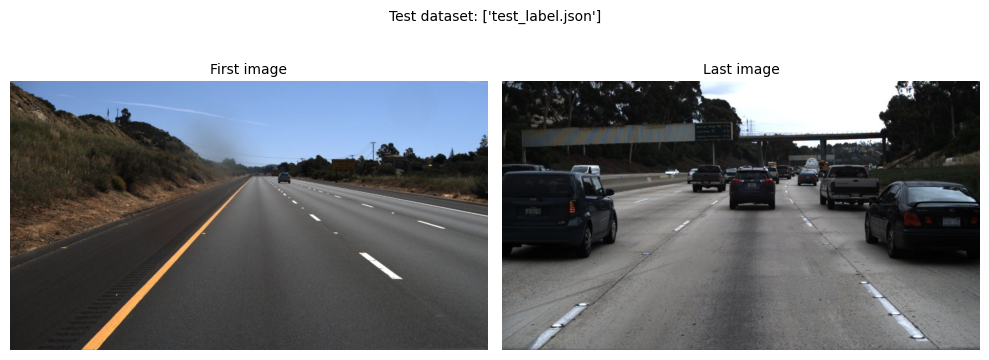

In [71]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(plt.imread(f"{test_dataset_path}/test_set/{test_data[0]['raw_file']}"))
plt.title('First image', size=10)
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(plt.imread(f"{test_dataset_path}/test_set/{test_data[len(test_data)-1]['raw_file']}"))
plt.title('Last image', size=10)
plt.axis('off')
plt.suptitle(f'Test dataset: {test_json}', size=10)
plt.tight_layout();

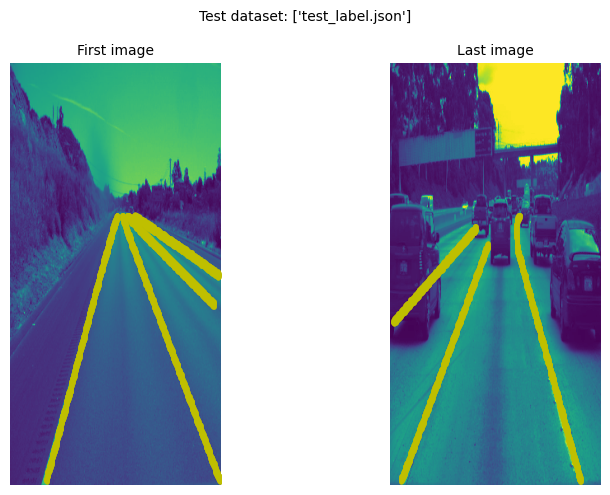

In [82]:
# Ground truth
lanes_dataset = LaneDataset(mode='test')
plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
im, seg, ins = lanes_dataset[0]
plt.scatter(x=ins.nonzero(as_tuple=True)[2], y=ins.nonzero(as_tuple=True)[1], s=5, c='y')
plt.imshow(im.squeeze())
plt.title('First image', size=10)
plt.axis('off')
plt.subplot(1, 2, 2)
im, seg, ins = lanes_dataset[-1]
plt.scatter(x=ins.nonzero(as_tuple=True)[2], y=ins.nonzero(as_tuple=True)[1], s=5, c='y')
plt.imshow(im.squeeze())
plt.title('Last image', size=10)
plt.axis('off')
plt.suptitle(f'Test dataset: {test_json}', size=10)
plt.tight_layout();

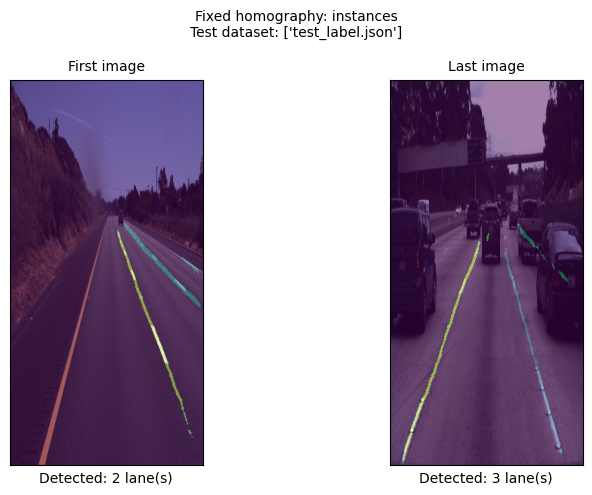

In [118]:
# Fixed homography: instances
plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
im_1 = plt.imread(f"{test_dataset_path}/test_set/{test_data[0]['raw_file']}")
detector = LaneDetector(hnet=None, lanenet=enet_model)
instances, predicted_lanes, n_lanes = detector(im_1)
plt.imshow(cv2.resize(im_1, DEFAULT_SIZE))
plt.imshow(instances, alpha=0.5)
plt.title('First image', size=10)
plt.xlabel(f'Detected: {n_lanes} lane(s)')
plt.xticks([])
plt.yticks([])
plt.xlim([0, 255])
plt.ylim([511, 0])
plt.subplot(1, 2, 2)
im_2 = plt.imread(f"{test_dataset_path}/test_set/{test_data[len(test_data) - 1]['raw_file']}")
detector = LaneDetector(hnet=None, lanenet=enet_model)
instances, predicted_lanes, n_lanes = detector(im_2)
plt.imshow(cv2.resize(im_2, DEFAULT_SIZE))
plt.imshow(instances, alpha=0.5)
plt.title('Last image', size=10)
plt.xlabel(f'Detected: {n_lanes} lane(s)')
plt.xticks([])
plt.yticks([])
plt.xlim([0, 255])
plt.ylim([511, 0])
plt.suptitle(f'Fixed homography: instances\nTest dataset: {test_json}', size=10)
plt.tight_layout();

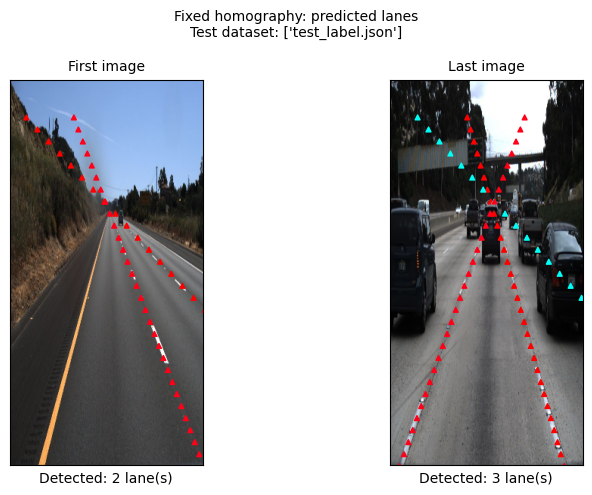

In [117]:
# Fixed homography: predicted lanes
plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
im_1 = plt.imread(f"{test_dataset_path}/test_set/{test_data[0]['raw_file']}")
detector = LaneDetector(hnet=None, lanenet=enet_model)
instances, predicted_lanes, n_lanes = detector(im_1)
plt.imshow(cv2.resize(im_1, DEFAULT_SIZE))
plt.scatter(x=predicted_lanes[:, 0], y=predicted_lanes[:, 1], c=predicted_lanes[:, 2], cmap='hsv', marker='^', s=12)
plt.title('First image', size=10)
plt.xlabel(f'Detected: {n_lanes} lane(s)')
plt.xticks([])
plt.yticks([])
plt.xlim([0, 255])
plt.ylim([511, 0])
plt.subplot(1, 2, 2)
im_2 = plt.imread(f"{test_dataset_path}/test_set/{test_data[len(test_data) - 1]['raw_file']}")
detector = LaneDetector(hnet=None, lanenet=enet_model)
instances, predicted_lanes, n_lanes = detector(im_2)
plt.imshow(cv2.resize(im_2, DEFAULT_SIZE))
plt.scatter(x=predicted_lanes[:, 0], y=predicted_lanes[:, 1], c=predicted_lanes[:, 2], cmap='hsv', marker='^', s=12)
plt.title('Last image', size=10)
plt.xlabel(f'Detected: {n_lanes} lane(s)')
plt.xticks([])
plt.yticks([])
plt.xlim([0, 255])
plt.ylim([511, 0])
plt.suptitle(f'Fixed homography: predicted lanes\nTest dataset: {test_json}', size=10)
plt.tight_layout();

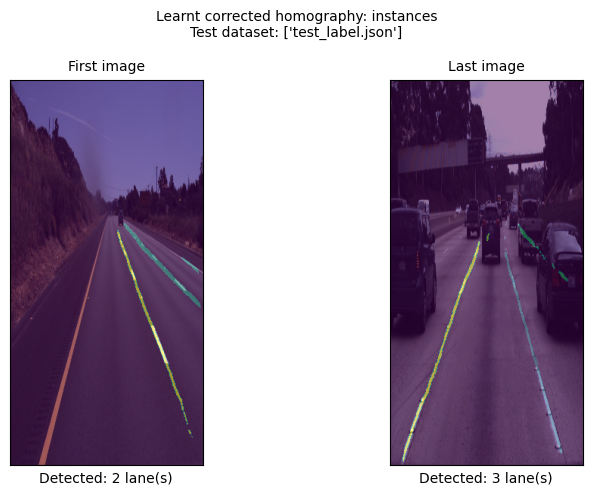

In [80]:
# Corrected homography: instances
plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
im_1 = plt.imread(f"{test_dataset_path}/test_set/{test_data[0]['raw_file']}")
detector = LaneDetector(hnet=hnet_model, lanenet=enet_model)
instances, predicted_lanes, n_lanes = detector(im_1)
plt.imshow(cv2.resize(im_1, DEFAULT_SIZE))
plt.imshow(instances, alpha=0.5)
plt.title('First image', size=10)
plt.xlabel(f'Detected: {n_lanes} lane(s)')
plt.xticks([])
plt.yticks([])
plt.xlim([0, 255])
plt.ylim([511, 0])
plt.subplot(1, 2, 2)
im_2 = plt.imread(f"{test_dataset_path}/test_set/{test_data[len(test_data) - 1]['raw_file']}")
detector = LaneDetector(hnet=hnet_model, lanenet=enet_model)
instances, predicted_lanes, n_lanes = detector(im_2)
plt.imshow(cv2.resize(im_2, DEFAULT_SIZE))
plt.imshow(instances, alpha=0.5)
plt.title('Last image', size=10)
plt.xlabel(f'Detected: {n_lanes} lane(s)')
plt.xticks([])
plt.yticks([])
plt.xlim([0, 255])
plt.ylim([511, 0])
plt.suptitle(f'Learnt corrected homography: instances\nTest dataset: {test_json}', size=10)
plt.tight_layout();

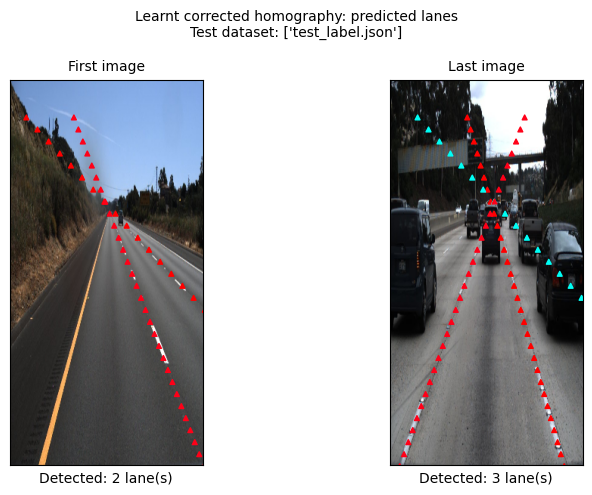

In [76]:
# Corrected homography: predicted lanes
plt.figure(figsize=(9, 5))
plt.subplot(1, 2, 1)
im_1 = plt.imread(f"{test_dataset_path}/test_set/{test_data[0]['raw_file']}")
detector = LaneDetector(hnet=hnet_model, lanenet=enet_model)
instances, predicted_lanes, n_lanes = detector(im_1)
plt.imshow(cv2.resize(im_1, DEFAULT_SIZE))
plt.scatter(x=predicted_lanes[:, 0], y=predicted_lanes[:, 1], c=predicted_lanes[:, 2], cmap='hsv', marker='^', s=12)
plt.title('First image', size=10)
plt.xlabel(f'Detected: {n_lanes} lane(s)')
plt.xticks([])
plt.yticks([])
plt.xlim([0, 255])
plt.ylim([511, 0])
plt.subplot(1, 2, 2)
im_2 = plt.imread(f"{test_dataset_path}/test_set/{test_data[len(test_data) - 1]['raw_file']}")
detector = LaneDetector(hnet=hnet_model, lanenet=enet_model)
instances, predicted_lanes, n_lanes = detector(im_2)
plt.imshow(cv2.resize(im_2, DEFAULT_SIZE))
plt.scatter(x=predicted_lanes[:, 0], y=predicted_lanes[:, 1], c=predicted_lanes[:, 2], cmap='hsv', marker='^', s=12)
plt.title('Last image', size=10)
plt.xlabel(f'Detected: {n_lanes} lane(s)')
plt.xticks([])
plt.yticks([])
plt.xlim([0, 255])
plt.ylim([511, 0])
plt.suptitle(f'Learnt corrected homography: predicted lanes\nTest dataset: {test_json}', size=10)
plt.tight_layout();

In [131]:
im, seg, ins = lanes_dataset[-1]
im.shape, ins.shape, seg.shape

(torch.Size([1, 512, 256]), torch.Size([1, 512, 256]), torch.Size([512, 256]))

In [100]:
im_1 = plt.imread(f"{test_dataset_path}/test_set/{test_data[-1]['raw_file']}")
detector = LaneDetector(hnet=None, lanenet=enet_model)
instances, predicted_lanes, n_lanes = detector(im_1)
instances.shape

(512, 256)

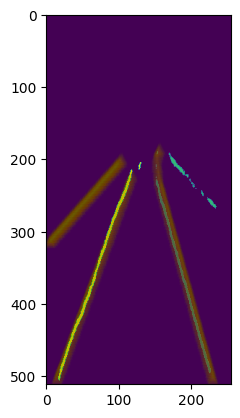

In [130]:
plt.scatter(x=ins.nonzero(as_tuple=True)[2], y=ins.nonzero(as_tuple=True)[1], marker='^', s=50, c='y', alpha=0.01)
plt.imshow(instances)

# <a id="summary"></a> Summary

We have successfully trained the ENet with accuracy on the train and validation datasets 0.98 after 10 epochs of training for binary segmentation predictions. The accuracy on the test data is also 0.98. We also trained the H-Net to learn homography corrections for the 6 degrees of freedom, to be used with the fixed homography. At the same, we cannot see much difference between lanes detected with the fixed and corrected homographies.